# Unsupervised Learning Project
## Police Equity

Source: [Kaggle Dataset](https://www.kaggle.com/datasets/center-for-policing-equity/data-science-for-good)

Task:
1. investigate the provided dataset towards homogeneous categories of similar policing incidents.  the geographic information is contained in the dataset and might be useful for the investigation of patterns within the data. The goal is to get a better overview over policing activities in your community which should, ultimately, lift the political discussion to a more informed level. 
2. Goal of this use case is to reduce the complexity of the dataset which is, at first, hard to overlook and to provide visualizations which capture the main characteristics of the whole dataset. 
3. For this purpose, you consider different techniques for dimensionality reduction. 
4. You should also provide insights into preferably homogeneous clusters of policing activities and visualizations, which allow to interpret these clusters. 
5. Finally, descriptive statistics about each group along with the number of incidents per cluster should be provided.

## PART 1: Data Structure and Loading



### Understanding the data structure
- collection of police behavioral data.
- data points such as use of force incidents, vehicle stops, pedestrian stops, calls for service, and crime data


In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
import zipfile
import warnings

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [2]:
%matplotlib widget
warnings.filterwarnings("ignore")
sns.set_style(style="white")

In [3]:
# run only once: 
if not os.path.exists('./data'):

    # Download data
    import kagglehub
    path = kagglehub.dataset_download("center-for-policing-equity/data-science-for-good")
    print("Path to dataset files:", path)
    
    # move the data to its desired location in proj directory (only one time)
    !mkdir ./data/
    !mv ~/.cache/kagglehub/datasets/center-for-policing-equity/data-science-for-good/ ./data/
    
else:
    print('path to data exists')
data_basepath = './data/data-science-for-good/versions/18'

path to data exists


In [4]:
# environment:
DATA_BASEPATH = "./data/data-science-for-good/versions/18"

# if the database scales, it makes sense to think about a more permanent solution,
# but right now for efficiency, the decoding of the cities will be hardcoded.
# (us states are coded, but nothing matches 37 being Texas, for example)
dept_city_codes = {
    "11-00091": {"city": "Boston", "address": "Boston, Massachusetts", "census": "25"},
    "23-00089": {
        "city": "Indianapolis",
        "address": "Indianapolis, Indiana",
        "census": "18",
    },
    "24-00013": {
        "city": "Minneapolis",
        "address": "Minneapolis, Minnesota",
        "census": "27",
    },
    "24-00098": {
        "city": "Saint Paul",
        "address": "Saint Paul, Minnesota",
        "census": "27",
    },
    "35-00016": {"city": "Orlando", "address": "Orlando, Florida", "census": "12"},
    "35-00103": {
        "city": "Charlotte Mecklenburg",
        "address": "Charlotte Mecklenburg, Florida",
        "census": "12",
    },
    "37-00027": {"city": "Austin", "address": "Austin, Texas", "census": "48"},
    "37-00049": {"city": "Dallas", "address": "Dallas, Texas", "census": "48"},
    "49-00009": {"city": "Seattle", "address": "Seattle, Washington", "census": "53"},
    "49-00033": {
        "city": "Los Angeles",
        "address": "Los Angeles, California",
        "census": "53",
    },
    "49-00035": {"city": "Oakland", "address": "Oakland, California", "census": "53"},
    "49-00081": {
        "city": "San Fransisco",
        "address": "San Fransisco, California",
        "census": "53",
    },
}

### Data Structure: 
The following cells show the data structure:
1. data is split to folders by police departments
2. each department has metadata and annotation files split by categories

**Shapefiles:** 
a set of related files that together define a geographic dataset
`.shp` - shape core file, contains actual shapes through geometric objects
`.shx` - shape index file for fast access to geometry in the `.shp`. used by tools like gpd. can provide table of contents for `.shp` 
`.dbf` — dBASE file with Attribute Data - Each row matches a shape (district name, population, etc.)
`.prj` - projection file with coordinate reference system (CRS), usually "EPSG:4326" or "ESRI:102739"
`.cst` - custom file for specific tools


In [5]:
DATA_BASEPATH = "./data/data-science-for-good/versions/18"
#!tree data/data-science-for-good/versions/18 -L 1

In [6]:
# examine structure of one departmemnt
#!tree data/data-science-for-good/versions/18/Dept_11-00091/

what are the two files in each subfolder stand for? 
- the metadata file includes the description similart to row[0] in the annotated file. 
- in the first measurement, there are 771 descriptors for every area (census) (total: 205 rows × 771 columns)
- wikipadia: 
A census tract, census area, census district or meshblock[1] is a geographic region defined for the purpose of taking a census (The procedure of systematically acquiring, recording, and calculating information about the members of a given population)... average about 4,000 inhabitants.
- the descriptors give statistical estimates: estimate, error margins, percent of population 
- each census has an id that functions similar to zip codes, but is geografically split differently. the mapping can be downloaded from the official statistical website of the US. 

In [7]:
# collect the csv file paths:
report_dfs = {}
report_descriptions = {}
for dept in dept_city_codes.keys():
    subfolder = os.path.join(DATA_BASEPATH, f"Dept_{dept}")
    report_csv = [f for f in os.listdir(subfolder) if f.endswith(".csv")][0]
    csv_path = os.path.join(subfolder, report_csv)
    df = pd.read_csv(
        csv_path,
        na_values=["NaN", "NA", "NON", "NO DATA ENTERED", "OTHER", 9999, "9999"],
    )

    # get the column description from the first row
    descriptions = df.iloc[0]
    description_pairs = {}
    for i in range(df.shape[1]):
        description_pairs[df.columns[i]] = descriptions[i]
    report_descriptions[dept] = description_pairs

    # drop the first row:
    df = df.drop([0])
    print(f"{dept}: shape: {df.shape}")

    report_dfs[dept] = df

11-00091: shape: (152230, 34)
23-00089: shape: (10274, 26)
24-00013: shape: (25801, 13)
24-00098: shape: (710472, 12)
35-00016: shape: (54, 21)
35-00103: shape: (77, 9)
37-00027: shape: (9482, 29)
37-00049: shape: (2383, 47)
49-00009: shape: (8687, 11)
49-00033: shape: (126854, 18)
49-00035: shape: (10769, 8)
49-00081: shape: (394235, 11)


In [8]:
dpt = "11-00091"
df11 = report_dfs[dpt]
df11_descriptions = report_descriptions[dpt]

## Part 2: Data Exploration and Cleaning PD 11-00091

Each district reports in a differently structured format. 
different column names and numbers
missing values
independent team names 
sometimes same column names have different content

the analysis will focus on pd 11-00091: Boston. 

Here we do not have decypherable address information, only neighborhoods

### General exploration and pre-processing

The columns initial analysis shows identifyer columns, as well as many categorical informations. the first view of the df shows a description of each column content in the first row. 



In [9]:
df11.describe()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,VEHICLE_DETAILS.1,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_ETHNICITY,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER,LOCATION_CITY
count,152230,152230,152230,152228,152205,152205,152230,152230,131331,146157,...,42030,135776.0,152228,151750.0,151750,23306,146157,152230,152220,67905
unique,152230,152230,3,38360,23,41,2140,2140,3,7,...,46,336.0,2845,47.0,25,1100,7,194,4665,21
top,938283,621880,MALE,TREMONT ST,B2,3,4/25/14 0:00,4/25/14 0:00,YES,B(Black),...,MA,11756.0,107106,16.0,YVSF,NH,B(Black),22,4771,Dorchester
freq,1,1,134264,949,40408,35627,222,222,113169,89219,...,38708,12788.0,2577,40553.0,45297,3174,89219,8293,7904,19407


FIO: Field interrogations and obsevations from the 
(BPD website)[https://data.boston.gov/dataset/boston-police-department-fio] 


already from lloking at the columns and descriptions several assumptions can be made regarding feature selection: 
The data features can be sorted out to id, incident related, subject related, vehicle related, officer/district related, and location. 
1.  incident identifiers: both have all unique values, one of them can be discarded (different systems) - there was a system switch in 2015. (acc. to the website) 
2. Gender: no missing values, the ruling majority of subjects are males. ~90%
3. Suspect details: priors - mostly yes, 113K/155K, and mostly black. 
clothing and complexion - might be irrelevant to predictions
4. incident time and date: later we find out that they are the same, and that all the day times are 00:00 

4. there are several location indicators - these sould be converted into coordinates for readability by the model and consistency with the shape files

In [10]:
df11[["INCIDENT_DATE"]].value_counts().sort_values(ascending=False)

INCIDENT_DATE
4/25/14 0:00     222
3/22/12 0:00     220
4/24/14 0:00     211
2/18/11 0:00     206
7/4/11 0:00      204
                ... 
2/21/05 0:00       1
2/21/08 0:00       1
2/21/73 0:00       1
2/21/89 0:00       1
2/22/07 0:00       1
Name: count, Length: 2140, dtype: int64

In [11]:
# check missing values:
df11.isna().sum().where(df11.isna().sum() > 0).dropna()

LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION         2.0
LOCATION_DISTRICT                                   25.0
LOCATION_DISTRICT.1                                 25.0
SUBJECT_DETAILS                                  20899.0
SUBJECT_RACE                                      6073.0
SUBJECT_DETAILS.1                                13469.0
SUBJECT_DETAILS.2                                25322.0
SEARCH_CONDUCTED                                131590.0
SEARCH_REASON                                   116686.0
INCIDENT_REASON                                  46908.0
DISPOSITION                                       8914.0
VEHICLE_MAKE                                    110844.0
VEHICLE_YEAR                                       181.0
VEHICLE_COLOR                                   112171.0
VEHICLE_MODEL                                   113317.0
VEHICLE_DETAILS                                 112243.0
VEHICLE_DETAILS.1                               110200.0
OFFICER_SUPERVISOR             

In [12]:
# datatypes are all objects - mapping a conversion method: 
columns_to_numeric = [
    "INCIDENT_UNIQUE_IDENTIFIER",
    "INCIDENT_UNIQUE_IDENTIFIER.1",
    "LOCATION_DISTRICT.1",
    "OFFICER_SUPERVISOR",
    "OFFICER_ID",
    "OFFICER_ASSIGNMENT",
    "OFFICER_AGE",
    "LOCATION_STREET_NUMBER",
]
columns_to_datetime = ["INCIDENT_DATE", "INCIDENT_TIME", "VEHICLE_YEAR"]

columns_to_drop = ["INCIDENT_UNIQUE_IDENTIFIER"]

In [13]:
# change data types
for col in columns_to_numeric:
    df11[col] = pd.to_numeric(df11[col], errors="coerce")

for col in columns_to_datetime:
    df11[col] = pd.to_datetime(df11[col], format="%m/%d/%y %H:%M", errors="coerce")

df11.dtypes

INCIDENT_UNIQUE_IDENTIFIER                               int64
INCIDENT_UNIQUE_IDENTIFIER.1                             int64
SUBJECT_GENDER                                          object
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION            object
LOCATION_DISTRICT                                       object
LOCATION_DISTRICT.1                                    float64
INCIDENT_DATE                                   datetime64[ns]
INCIDENT_TIME                                   datetime64[ns]
SUBJECT_DETAILS                                         object
SUBJECT_RACE                                            object
SUBJECT_DETAILS.1                                       object
SUBJECT_DETAILS.2                                       object
UNKNOWN_FIELD_TYPE                                      object
UNKNOWN_FIELD_TYPE.1                                    object
SEARCH_CONDUCTED                                        object
SEARCH_REASON                                          

In [14]:
# the data is supposed to contain information about 2011-2015
df11[["INCIDENT_DATE"]].loc[df11["INCIDENT_DATE"].dt.year < 2010].count()

INCIDENT_DATE    488
dtype: int64

### Cleaning time related columnns:

In [15]:
# suspicion: that the date and time are just date:
# split the time of day to check.If time exists, it can be used for time-of-day-based analysis

time_df = df11[["INCIDENT_DATE", "INCIDENT_TIME"]]

time_df["date_hr"] = time_df["INCIDENT_DATE"].dt.hour
time_df["time_hr"] = time_df["INCIDENT_TIME"].dt.hour
time_df["date_min"] = time_df["INCIDENT_DATE"].dt.minute
time_df["time_min"] = time_df["INCIDENT_TIME"].dt.minute

In [16]:
# as suspected, all hours of the day are set to 00:00.
time_df.loc[time_df["date_hr"] != 0].shape[0]  # returns 0
time_df.loc[time_df["date_min"] != 0].shape[0]  # returns 0

0

In [17]:
# check that date and time are identicle
time_df["INCIDENT_DATE"].equals(time_df["INCIDENT_TIME"])  # returns: True

True

In [18]:
# mark incident_time for deletion
columns_to_drop.append("INCIDENT_TIME")

In [19]:
# create year month and weekday columns, for seasonality recognition
df11["MONTH"] = time_df["INCIDENT_DATE"].dt.month
df11["YEAR"] = time_df["INCIDENT_DATE"].dt.year
df11["WEEKDAY"] = time_df["INCIDENT_DATE"].dt.weekday

### Cleaning subject related columns

In [20]:
subject_df = df11[
    [
        "SUBJECT_GENDER",
        "SUBJECT_DETAILS",
        "SUBJECT_RACE",
        "SUBJECT_DETAILS.1",
        "SUBJECT_DETAILS.2",
        "DISPOSITION",
    ]
]

# unknown and unknown.1 are 'incident type' and 'terrorism' respectively same with incident reason and incident_reason.1 (fios)
incident_df = df11[
    [
        "INCIDENT_UNIQUE_IDENTIFIER.1",
        "UNKNOWN_FIELD_TYPE",
        "UNKNOWN_FIELD_TYPE.1",
        "SEARCH_CONDUCTED",
        "SEARCH_REASON",
        "INCIDENT_REASON",
        "INCIDENT_REASON.1",
    ]
]
officer_df = df11[
    [
        "OFFICER_SUPERVISOR",
        "OFFICER_ID",
        "OFFICER_ASSIGNMENT",
        "OFFICER_ASSIGNMENT.1",
        "OFFICER_ETHNICITY",
        "OFFICER_RACE",
        "OFFICER_AGE",
    ]
]

from the bpd website: Outcome:  S=Seizure, F=FIO, O=Other
(https://data.boston.gov/dataset/boston-police-department-fio/resource/1e5f1bc5-a0b4-4dce-ae1c-7c01ab3364f6)

In [21]:
# columns with subject details discriptions are the ones with the most missing values- up to 13% from the data. 
subject_df.isna().sum().where(subject_df.isna().sum() > 0).dropna()

SUBJECT_DETAILS      20899.0
SUBJECT_RACE          6073.0
SUBJECT_DETAILS.1    13469.0
SUBJECT_DETAILS.2    25322.0
DISPOSITION           8914.0
dtype: float64

In [22]:
subject_df["SUBJECT_RACE"].value_counts()
subject_df["SUBJECT_DETAILS"].value_counts()
subject_df["SUBJECT_DETAILS.2"].value_counts()
subject_df["DISPOSITION"].value_counts()

DISPOSITION
F      131470
FO       5075
SF       2816
S        1659
O        1493
SFO       746
SO         57
Name: count, dtype: int64

In [23]:
# fillna with 'unknown' and 'O' - observation values
# subject race, subject_details (= priors), subject_details.2 (=complextion): convert NA to 'unknown' category

subject_df["SUBJECT_RACE"] = subject_df["SUBJECT_RACE"].fillna("UNKNOWN")
subject_df["SUBJECT_DETAILS"] = subject_df["SUBJECT_DETAILS"].fillna("UNKNOWN")
subject_df["SUBJECT_DETAILS.2"] = subject_df["SUBJECT_DETAILS.2"].fillna("UNKNOWN")
subject_df["DISPOSITION"] = subject_df["DISPOSITION"].fillna("O")

In [24]:
# subject_details_1: clothing has free text input with 100K+ unique values. this will be dropped.
columns_to_drop.append("SUBJECT_DETAILS.1")

### Cleaning officer related columns

In [25]:
# check the district columns to complete the assignment data
officer_df[["LOCATION_DISTRICT", "LOCATION_DISTRICT.1"]] = df11[
    ["LOCATION_DISTRICT", "LOCATION_DISTRICT.1"]
]
officer_df.isna().sum().where(officer_df.isna().sum() > 0).dropna()

OFFICER_SUPERVISOR       16454.0
OFFICER_ID                   2.0
OFFICER_ASSIGNMENT         480.0
OFFICER_ASSIGNMENT.1       480.0
OFFICER_ETHNICITY       128924.0
OFFICER_RACE              6073.0
LOCATION_DISTRICT           25.0
LOCATION_DISTRICT.1         25.0
dtype: float64

In [26]:
df11[
    [
        "LOCATION_DISTRICT",
        "LOCATION_DISTRICT.1",
        "OFFICER_ASSIGNMENT",
        "OFFICER_ASSIGNMENT.1",
    ]
].head()

,LOCATION_DISTRICT,LOCATION_DISTRICT.1,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1
1,B2,3.0,NaN,NaN
2,A1,1.0,1.0,A1
3,C11,5.0,16.0,YVSF
4,B2,3.0,25.0,BIKE
5,B2,3.0,3.0,B2


In [27]:
# officer assignment: destrict, officer assignment.1: district id

# in most cases, the officer assignment is the location district
officer_df["OFFICER_ASSIGNMENT"].value_counts()
officer_df[["OFFICER_ASSIGNMENT", "LOCATION_DISTRICT", "LOCATION_DISTRICT.1"]].loc[
    officer_df["OFFICER_ASSIGNMENT.1"].isna()
].value_counts()

# check relationship between officer assignemnts and location districts
officer_df[
    [
        "OFFICER_ASSIGNMENT",
        "OFFICER_ASSIGNMENT.1",
        "LOCATION_DISTRICT",
        "LOCATION_DISTRICT.1",
    ]
].loc[officer_df["OFFICER_ASSIGNMENT.1"] == "E5"].value_counts()

# Officer Ethnicity - there are too many missing values (130K), sometimes contradicting with officer_race, so this will be dropped
#  same officer ID with and without the race in some of the report:
officer_df[["OFFICER_ID", "OFFICER_ETHNICITY", "OFFICER_RACE"]].groupby(
    "OFFICER_ID"
).value_counts()

# these will be filled from the other reports the same officers gave.
# 15 officer_race missing values remained. 
officer_df["DISPOSITION"] = df11["DISPOSITION"]
officer_df[["OFFICER_ID", "OFFICER_ETHNICITY", "OFFICER_RACE", "DISPOSITION"]].loc[
    officer_df["OFFICER_RACE"].isna()
]

officer_df["OFFICER_RACE"] = officer_df.groupby("OFFICER_ID")["OFFICER_RACE"].transform(
    lambda x: x.fillna(method="ffill").fillna(method="bfill")
)

officer_df[
    [
        "OFFICER_ASSIGNMENT",
        "OFFICER_ASSIGNMENT.1",
        "LOCATION_DISTRICT",
        "LOCATION_DISTRICT.1",
    ]
]

officer_df["OFFICER_ASSIGNMENT.1"] = officer_df["OFFICER_ASSIGNMENT.1"].fillna(
    "LOCATION_DISTRICT"
)
officer_df["OFFICER_ASSIGNMENT"] = officer_df["OFFICER_ASSIGNMENT"].fillna(
    "LOCATION_DISTRICT.1"
)

officer_df.isna().sum().where(officer_df.isna().sum() > 0).dropna()

OFFICER_SUPERVISOR      16454.0
OFFICER_ID                  2.0
OFFICER_ETHNICITY      128924.0
OFFICER_RACE               17.0
LOCATION_DISTRICT          25.0
LOCATION_DISTRICT.1        25.0
DISPOSITION              8914.0
dtype: float64

In [28]:
officer_df[["OFFICER_ID", "OFFICER_SUPERVISOR", "LOCATION_DISTRICT"]].groupby(
    "LOCATION_DISTRICT"
).count()

,OFFICER_ID,OFFICER_SUPERVISOR
LOCATION_DISTRICT,,
A1,15655,15617
A15,2035,2030
A7,5660,5654
Auto,50,47
B2,40406,37762
B3,24201,24051
BIKE,44,37
BMP,38,37
C11,20586,19995


In [29]:
# columns to dropna
col_to_dropna = ["OFFICER_ID", "OFFICER_RACE"]

# columns to drop outliers: some of the officers have age lower than 18 (around 1000)
cols_drop_outliers = ["OFFICER_AGE"]

# disposition: will be replaced with "O=Other" acc.to the BPD keys
col_to_fillna_with_value = {
    "SUBJECT_RACE": "UNKNOWN",
    "SUBJECT_DETAILS": "UNKNOWN",
    "SUBJECT_DETAILS.2": "UNKNOWN",
    "DISPOSITION": "O",
    "OFFICER_SUPERVISOR": 0,
}

# fillna with another column:
columns_to_fillna_values = {
    "OFFICER_ASSIGNMENT.1": "LOCATION_DISTRICT",
    "OFFICER_ASSIGNMENT": "LOCATION_DISTRICT.1",
}

# the location appears twice in name and id, one is redundant. 'LOCATION_DISTRICT' will be kept, to match the coding in the shape files.
columns_to_drop.extend(
    ["OFFICER_ETHNICITY", "OFFICER_ASSIGNMENT", "LOCATION_DISTRICT.1"]
)

### Cleaning interrogation related Data

Unknown: FIO type (field interrogation and observation) Flag indicating what actions where taken during the FIO:  I=Interogated, O=Observed, F=Frisked, S=Search
Unknown 1: Terrorism (yes no)

Search conducted: Flag indicating what was searched: V=Vehicle, P=Person

In [30]:
# search conducted: many missing values, cover3ed under unknown. therefore will be dropped
incident_df.isna().sum()

INCIDENT_UNIQUE_IDENTIFIER.1         0
UNKNOWN_FIELD_TYPE                   0
UNKNOWN_FIELD_TYPE.1                 0
SEARCH_CONDUCTED                131590
SEARCH_REASON                   116686
INCIDENT_REASON                  46908
INCIDENT_REASON.1                    0
dtype: int64

In [31]:
incident_df[["INCIDENT_REASON.1"]].loc[
    ~incident_df["INCIDENT_REASON"].isna()
].value_counts()

INCIDENT_REASON.1                   
INVESTIGATE, PERSON                     64472
VAL                                     11817
TRESPASSING                              3602
DRUGS, INVESTIGATION                     2962
INVESTIGATE, MV                          2947
                                        ...  
RECOVERED STOLEN PLATE                      1
PROPERTY, LOST                              1
PRISONER RELEASE                            1
SEX-ASSAULT, INDECENT A&B (UNDER 14)        1
SEX-ASSAULT, SEARCH WARRANT EXECUTED        1
Name: count, Length: 210, dtype: int64

In [32]:
# SEARCH_CONDUCTED  and SEARCH_REASON and INCIDENT_REASON
# all have many missing values and some equivalents in 'unknown field type' and 'incident reason 1'.
columns_to_drop.extend(["SEARCH_CONDUCTED", "SEARCH_REASON", "INCIDENT_REASON"])

### cleaning vehicle related data

In [33]:
# most of the data is missing, we will ignore this data for now.
df11_descriptions["VEHICLE_DETAILS.1"]  # vehicle state
df11_descriptions["VEHICLE_DETAILS"]  # vehicle occupant

'VEH_OCCUPANT'

In [34]:
columns_to_drop.extend(
    [
        "VEHICLE_MAKE",
        "VEHICLE_YEAR",
        "VEHICLE_COLOR",
        "VEHICLE_MODEL",
        "VEHICLE_DETAILS",
        "VEHICLE_DETAILS.1",
    ]
)

In [35]:
# fillna with values from the same column, based on another column:
df11["OFFICER_RACE"] = df11.groupby("OFFICER_ID")["OFFICER_RACE"].transform(
    lambda x: x.fillna(method="ffill").fillna(method="bfill")
)
df11["OFFICER_SUPERVISOR"] = df11.groupby("LOCATION_DISTRICT.1")[
    "OFFICER_SUPERVISOR"
].transform(lambda x: x.fillna(method="ffill").fillna(method="bfill"))

# fillna for remaining values with mode (most frequent) value:
df11["OFFICER_RACE"] = df11["OFFICER_RACE"].fillna(df11["OFFICER_RACE"].mode())

In [36]:
for col in col_to_dropna:
    df11[col] = df11[col].dropna()

for col, value in col_to_fillna_with_value.items():
    df11[col] = df11[col].fillna(value)

for col, value in columns_to_fillna_values.items():
    df11[col] = df11[col].fillna(df11[value])

df11 = df11.drop(columns=columns_to_drop)

In [37]:
# most of the cases wehre the age is lower than 18 belong to outcome 'investigate, person'
df11 = df11.drop(df11[df11["OFFICER_AGE"] < 18].index)
df11 = df11.drop(df11[df11["OFFICER_AGE"] > 89].index)

In [38]:
# we are left with around 30 missing values not related to location, which we can drop
print(df11.isna().sum())
df11.dropna(subset=["OFFICER_ID", "OFFICER_RACE", "OFFICER_ASSIGNMENT.1"], inplace=True)
df11.shape

INCIDENT_UNIQUE_IDENTIFIER.1                        0
SUBJECT_GENDER                                      0
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        2
LOCATION_DISTRICT                                  20
INCIDENT_DATE                                       0
SUBJECT_DETAILS                                     0
SUBJECT_RACE                                        0
SUBJECT_DETAILS.2                                   0
UNKNOWN_FIELD_TYPE                                  0
UNKNOWN_FIELD_TYPE.1                                0
INCIDENT_REASON.1                                   0
DISPOSITION                                         0
OFFICER_SUPERVISOR                                  0
OFFICER_ID                                          2
OFFICER_ASSIGNMENT.1                                8
OFFICER_RACE                                       10
OFFICER_AGE                                         0
LOCATION_STREET_NUMBER                              7
LOCATION_CITY               

(137907, 22)

### Processing location related columns

In [39]:
# location street number:
# this column includes different numbering than the actual numbers in the full-address columns. it relates to 'street-id',
#  by the keys on BPD website: "Unique ID for the street used in the location field"
# it is not mentioned in the shape files, therefore it is not required.
# location city: since the address and the district id number is existing, this column is not required. it represents the city part of the incident

In [40]:
loc_df = df11[
    [
        "LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION",
        "LOCATION_STREET_NUMBER",
        "LOCATION_CITY",
        "LOCATION_DISTRICT",
    ]
]
loc_df.dropna(inplace=True, subset=["LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION"])
loc_df.isna().sum()

LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        0
LOCATION_STREET_NUMBER                              7
LOCATION_CITY                                   76279
LOCATION_DISTRICT                                  12
dtype: int64

In [41]:
# sandardize the address for the shape files:
import usaddress
import re

def get_geocode_with_errors(address_string):

    intersection_keywords = re.compile(r"\s+(?:at|and|&|@|/)\s+", re.IGNORECASE)

    try:
        if intersection_keywords.search(address_string):
            splits = intersection_keywords.split(address_string, 1)
            address_to_tag = splits[0]

        else:
            address_to_tag = address_string

        full_address = usaddress.tag(address_to_tag)[0]
        house = full_address.get("AddressNumber")
        street = full_address.get("StreetName")

        return pd.Series([house, street])

    except Exception as e:
        print(e)
        print(address_string)
        return pd.Series([None, None])

In [42]:
# concat city and state to the address:
city_state = dept_city_codes[dpt]["address"]

def concat_string_city_state(address, city_state):
    return address + ", " + city_state

loc_df["full_address"] = (
    loc_df["LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION"] + " " + city_state
)



In [43]:
#  the addresses are missing street numbers, or are not written in a standardized format that is recognizable by 
# open street view or usa standard address books. (usaddress). it is impossible to relate to a district with address indicator
loc_df[["street_number", "street_name"]] = loc_df["full_address"].apply(
    get_geocode_with_errors
)

In [44]:
# delete locations which are not districts: these are around 500 data points
non_districts = df11['LOCATION_DISTRICT'].value_counts().where(df11['LOCATION_DISTRICT'].value_counts() < 300).dropna().index
non_districts

df11 = df11.drop(df11[df11["LOCATION_DISTRICT"].isin(non_districts)].index)

In [45]:
# fillna of location
# most frequent street in district:
# transform keeps the order of the original column
mode_districts = loc_df.groupby("street_name")["LOCATION_DISTRICT"].transform(
    lambda x: x.mode()[0]
)

# fillna with the district of the most common name
loc_df["LOCATION_DISTRICT"].fillna(mode_districts, inplace=True)

In [46]:
# add teh new column:s
df11[["street_number", "street_name"]] = loc_df[["street_number", "street_name"]]
df11["LOCATION_DISTRICT"] = loc_df.LOCATION_DISTRICT

# dropna addresses 
df11.dropna(inplace=True, subset=["LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION"])

# this leaves us with 3, we will drop them.
df11.dropna(subset=["LOCATION_DISTRICT"], inplace=True)

In [47]:
df11.to_csv('./data/processed_csv/00_df11.csv', index=False)

## EDA

In [48]:
clean_df11 = df11.drop(
    columns=[
        "LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION",
        "LOCATION_CITY",
        "LOCATION_STREET_NUMBER",
        "street_number",
        "street_name",
    ]
)
clean_df11.head(2)

,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_DISTRICT,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE,MONTH,YEAR,WEEKDAY
1,621880,MALE,B2,2013-12-10,YES,B(Black),Med,IOFS,NO,"DRUGS, INVESTIGATION",SFO,10132.0,98656.0,B2,B(Black),59,12,2013,1
2,565177,MALE,A1,2012-05-24,NO,W(White),Med,IO,NO,"DRUGS, POSSESSION",F,8949.0,9765.0,A1,W(White),26,5,2012,3


In [49]:
clean_df11.rename(
    columns={
        "SUBJECT_DETAILS": "SUBJECT_PRIORS",
        "SUBJECT_DETAILS.2": "SUBJECT_COMPLEXTION",
        "UNKNOWN_FIELD_TYPE": "FIOFS_TYPE",
        "UNKNOWN_FIELD_TYPE.1": "TERRORISM",
        "INCIDENT_REASON.1": "VIOLATION_REASON",
        "DISPOSITION": "OUTCOME",
    },
    inplace=True,
)

In [50]:
# feature enrichment: 


# extract month_year for continuous time measurement: 
clean_df11["month_year"] = clean_df11["INCIDENT_DATE"].dt.to_period("M")

# pd.cut: create age group buckets (docs: This function is also useful for going from a continuous variable to a categorical variable. For example, cut could convert ages to groups of age ranges. )

# bin officer age group: 
bins = [17, 30, 40, 50, 60, 70, 100]
labels = ["18-30", "31-40", "41-50", "51-60", "61-70", "70+"]
clean_df11["OFFICER_AGE_GROUP"] = pd.cut(
    clean_df11["OFFICER_AGE"], bins=bins, labels=labels
)

### Initial variable examination: 

In [51]:
# subject race split:
grouped_race_gender = (
    clean_df11.groupby(["SUBJECT_GENDER", "SUBJECT_RACE"])
    .size()
    .unstack(fill_value=0)
    .T
)
grouped_race_gender

SUBJECT_GENDER,FEMALE,MALE,UNKNOWN
SUBJECT_RACE,,,
A(Asian or Pacific Islander),182,985,0
B(Black),6299,74279,4
H(Hispanic),1343,16310,5
I(American Indian or Alaskan Native),8,54,0
M(Middle Eastern or East Indian),28,397,0
UNKNOWN,289,4513,186
W(White),8117,24373,3


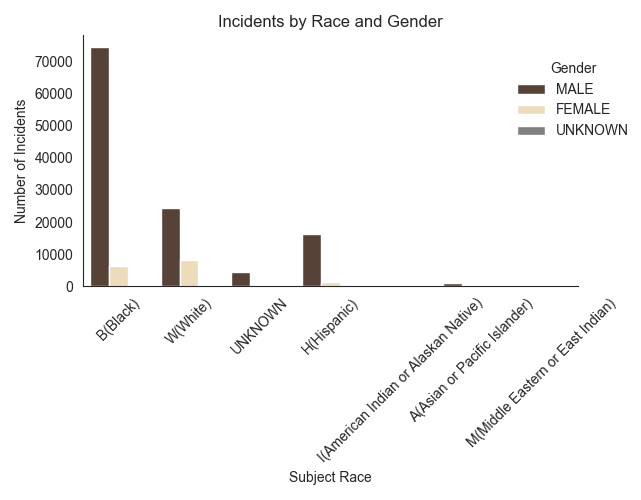

In [117]:
p = sns.catplot(
    x="SUBJECT_RACE",
    palette=["#5C4033", "#F5DEB3", "#808080"],
    hue="SUBJECT_GENDER",
    data=clean_df11,
    kind="count",
)

p._legend.set_title("Gender")
p._legend.set_bbox_to_anchor([1, 0.8])
plt.rcParams["figure.figsize"] = 5, 5
plt.title("Incidents by Race and Gender")
plt.xlabel("Subject Race")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

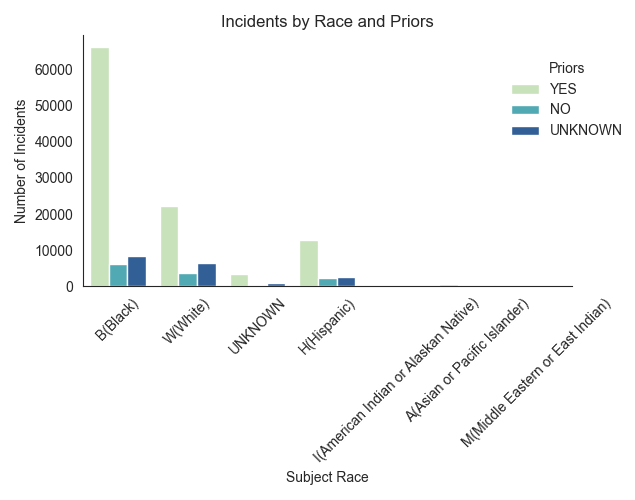

In [116]:
# incidents by race and priors
# subject race split:
grouped_race_priors = (
    clean_df11.groupby(["SUBJECT_PRIORS", "SUBJECT_RACE"])
    .size()
    .unstack(fill_value=0)
    .T
)

p = sns.catplot(
    x="SUBJECT_RACE",
    palette="YlGnBu",  # ["#5C4033", "#F5DEB3", "#808080"],
    hue="SUBJECT_PRIORS",
    data=clean_df11,
    kind="count",
)

p._legend.set_title("Priors")
p._legend.set_bbox_to_anchor([1, 0.8])
plt.rcParams["figure.figsize"] = 6, 6
plt.title("Incidents by Race and Priors")
plt.xlabel("Subject Race")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

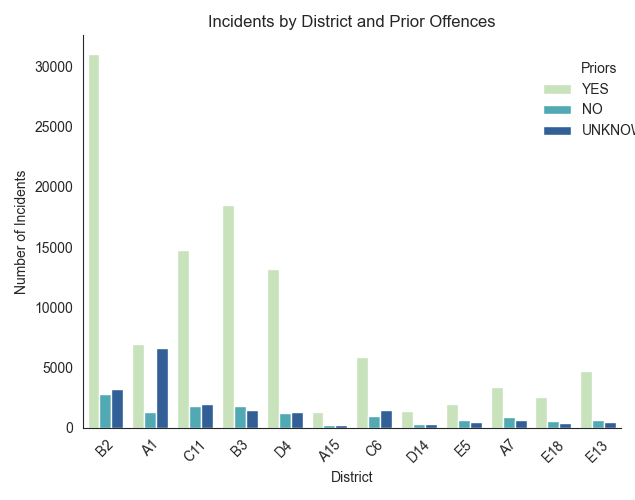

In [112]:
# priors by district
district_priors = clean_df11.copy()


district_priors["SUBJECT_PRIORS"] = pd.Categorical(
    district_priors["SUBJECT_PRIORS"],
    categories=["YES", "NO", "UNKNOWN"],   
    ordered=False
)
# fig, ax = plt.subplots(figsize=(5, 5))
p = sns.catplot(
    x="LOCATION_DISTRICT",
    palette="YlGnBu",  # ["#5C4033", "#F5DEB3", "#808080"],
    hue="SUBJECT_PRIORS",
    data=district_priors,
    kind="count",
)

p._legend.set_title("Priors")
p._legend.set_bbox_to_anchor([1.05, 0.8])
plt.title("Incidents by District and Prior Offences")
plt.xlabel("District")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

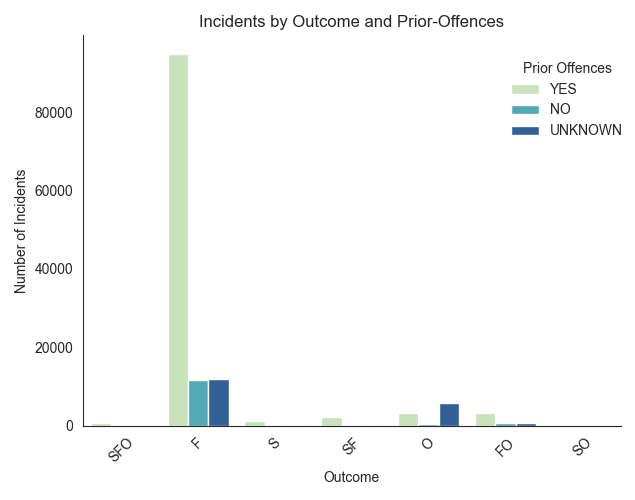

In [115]:
# interrogation outcome by priors
grouped_district_priors = (
    clean_df11.groupby(["OUTCOME", "SUBJECT_PRIORS"]).size().unstack(fill_value=0).T
)
p = sns.catplot(
    x="OUTCOME",
    palette="YlGnBu",
    hue="SUBJECT_PRIORS",
    data=clean_df11,
    kind="count",
    # legend=False
)
# plt.legend(title='Outcomes',labels=['Seized+Frisked+Observed', 'Frisked', 'Seized', 'Seized+Frisked', 'Observed', 'Frisked+Observed', 'Seized+Observed'])
p._legend.set_title("Prior Offences")
p._legend.set_bbox_to_anchor([1, 0.8])
plt.title("Incidents by Outcome and Prior-Offences")
plt.xlabel("Outcome")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Correlations

cont-cont: Pearson: covariance around the mean, standardized by the std
cat-cat: Cramer’s V using chi square test: do the variables have the same distribution
cant-cont: Point-biserial correlation

In [56]:
# distribution of incidents by day of the week

# distribution of the offiecr ages: some outliers, some officers are 1 year old
clean_df11["WEEKDAY"].hist(bins=7, edgecolor="white")
plt.title("Incident Distribution by weekday")
plt.xlabel("Day")
plt.ylabel("Incidents")

Text(48.54166397452356, 0.5, 'Incidents')

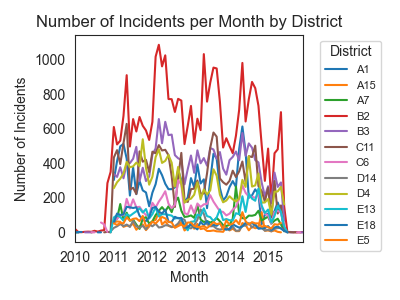

In [ ]:
# incidents per day along time:
# is there  more or less crime through the time?
incidents_per_month = (
    clean_df11.groupby(["month_year", "LOCATION_DISTRICT"])
    .size()
    .reset_index(name="count")
)
pivot_df = incidents_per_month.pivot(
    index="month_year", columns="LOCATION_DISTRICT", values="count"
)

pivot_df.loc[(pivot_df.index.year >= 2010) & (pivot_df.index.year <= 2015)].plot(
    kind="line", figsize=(4, 3)
)
plt.title("Monthly Number of Incidents by District")
plt.xlabel("Month")
plt.ylabel("Number of Incidents")
plt.legend(title="District", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

There is no clear development in the amount of the incidents, however there is some seaonality in 2 peaks that can be seen in many of the districts in the first half of the years.
leading is B2, that has the most amount of incidentsin general. 

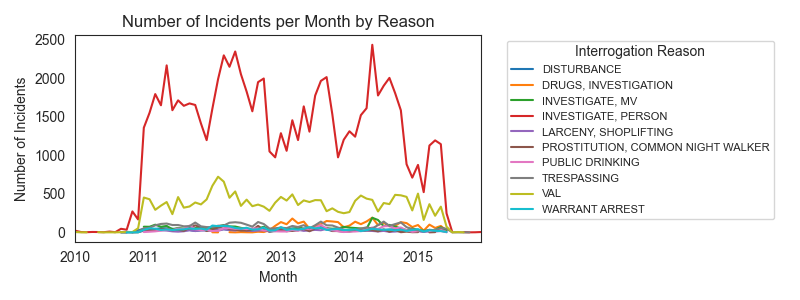

In [108]:
# which reasons are for crimes along times and districts
top_10_reasons = clean_df11["VIOLATION_REASON"].value_counts().head(10).index
df_top10 = clean_df11[clean_df11["VIOLATION_REASON"].isin(top_10_reasons)].copy()
df_top10["YEAR_MONTH"] = df_top10["INCIDENT_DATE"].dt.to_period("M")
monthly_top10 = (
    df_top10.groupby(["YEAR_MONTH", "VIOLATION_REASON"])
    .size()
    .reset_index(name="count")
)


pivot_df = monthly_top10.pivot(
    index="YEAR_MONTH", columns="VIOLATION_REASON", values="count"
)
pivot_df.loc[(pivot_df.index.year >= 2010) & (pivot_df.index.year <= 2015)].plot(
    kind="line", figsize=(8, 3)
)
plt.title("Number of Incidents per Month by Reason")
plt.xlabel("Month")
plt.ylabel("Number of Incidents")
plt.legend(title="Interrogation Reason", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# A&B typically stands for Assault and Battery.
# Affray fighting or threatening violence by one or more people
# VAL is most likely a shortened term for Violation of the Alcohol Law

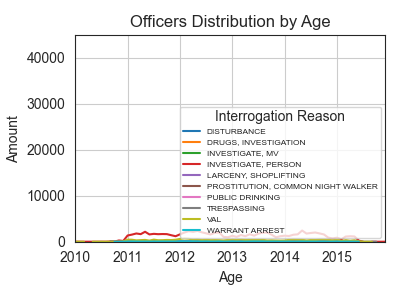

In [59]:
# distribution of the offiecr ages: some outliers, some officers are 1 year old
clean_df11["OFFICER_AGE"].hist(
    bins=20, range=[0, 100], edgecolor="white", figsize=(4, 3)
)
plt.title("Officers Distribution by Age")
plt.xlabel("Age")
plt.ylabel("Amount")
plt.show()

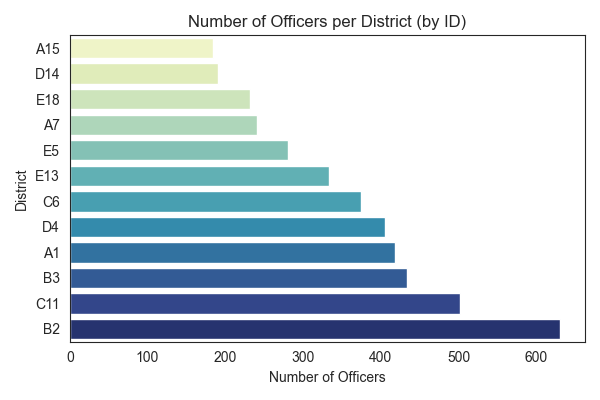

In [60]:
# how many officers per district?
officers_per_dist = (
    clean_df11[["OFFICER_ID", "LOCATION_DISTRICT"]]
    .groupby("LOCATION_DISTRICT")["OFFICER_ID"]
    .nunique()
    .reset_index(name="unique_officers")
    .sort_values("unique_officers", ascending=True)
)
plt.figure(figsize=(6, 4))
sns.barplot(
    data=officers_per_dist, x="unique_officers", y="LOCATION_DISTRICT", palette="YlGnBu"
)
plt.title("Number of Officers per District (by ID)")
plt.xlabel("Number of Officers")
plt.ylabel("District")
plt.tight_layout()
plt.show()

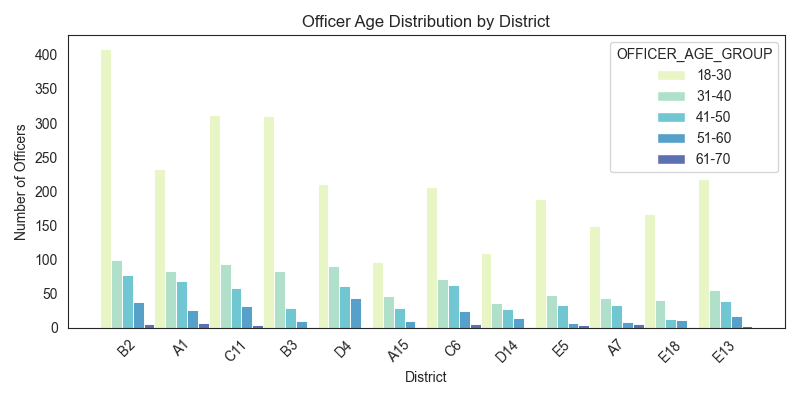

In [61]:
# Drop duplicates to get one row per officer per district:
# since there are more than 1 year, need to account for the different age in different years
unique_officers = clean_df11[
    ["OFFICER_ID", "OFFICER_AGE", "LOCATION_DISTRICT"]
].drop_duplicates(subset=["OFFICER_ID", "LOCATION_DISTRICT"])
unique_officers

bins = [17, 30, 40, 50, 60, 70]
labels = ["18-30", "31-40", "41-50", "51-60", "61-70"]
unique_officers["OFFICER_AGE_GROUP"] = pd.cut(
    unique_officers["OFFICER_AGE"], bins=bins, labels=labels
)

plt.figure(figsize=(8, 4))
g = sns.histplot(
    data=unique_officers,
    x="LOCATION_DISTRICT",
    hue="OFFICER_AGE_GROUP",
    multiple="dodge",  # 'stack' or 'dodge' for side-by-side
    palette="YlGnBu",
    binwidth=5,
)

plt.title("Officer Age Distribution by District")
plt.xlabel("District")
plt.xticks(rotation=45)
# plt.legend([], [], frameon=False)  # otherwise the legend is disturbing the shape of the fig
plt.ylabel("Number of Officers")
plt.tight_layout()
plt.show()

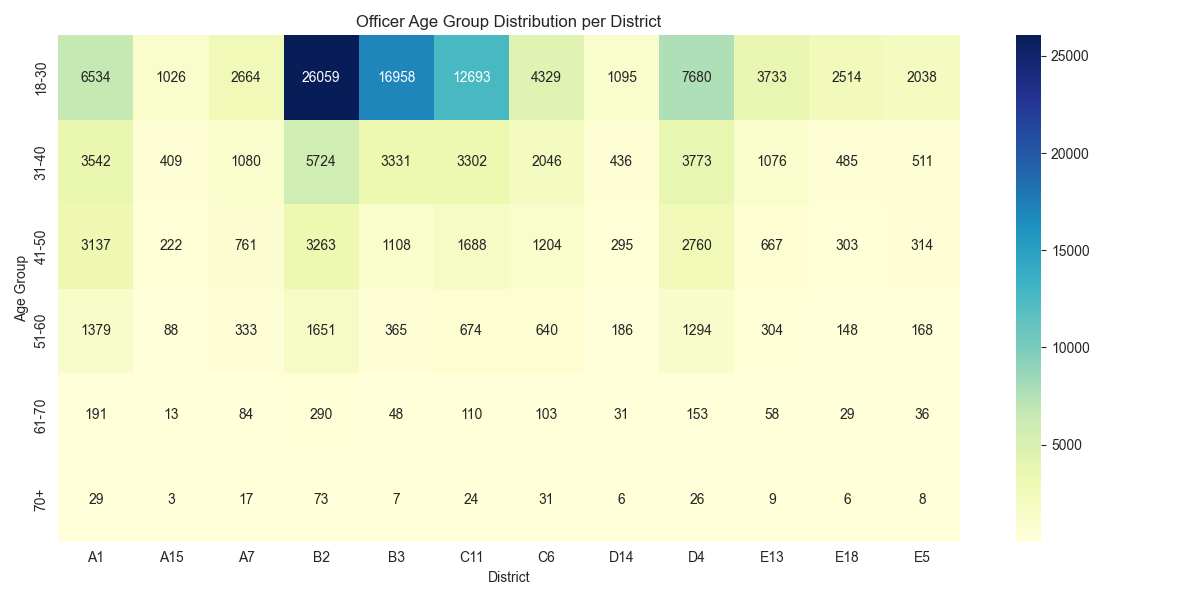

In [62]:
# split of officer age by districts


# create pivotable
pivot_age_dist = clean_df11.pivot_table(
    index="OFFICER_AGE_GROUP",
    columns="LOCATION_DISTRICT",
    values="OFFICER_ID",
    aggfunc="count",
    fill_value=0,
)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_age_dist, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Officer Age Group Distribution per District")
plt.xlabel("District")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()

feature enrichment: 
in order to be able to draw conclusions regarding the type of incident and the outcome, these have to be standardized and enriched

we want to convert the data into numbers in order to be able to find variances and run clustering

mapping out of the column type: 
id - cont but irrelevant
s.gender - cat
s.location - cat                        one hot
date - cont
s_priors - cat
s_race - cat
s_complextion - cat
fiofs_type - cat
TERRORISM - cat
VIOLATION_REASON - cat
OUTCOME - cat
OFFICER_SUPERVISOR - ordinal            norm
OFFICER_ID - ordinal                    norm
OFFICER_ASSIGNMENT.1 - cat              one hot 
'OFFICER_RACE - act                     one hot 
OFFICER_AGE - ordinal                   
MONTH - cat                             
YEAR - cat
month_year - ordinal
GROUPED_VIOLATION_REASON - cat
OFFICER_AGE_GROUP - cat 

In [63]:
clean_df11[["OFFICER_ID", "OFFICER_SUPERVISOR", "OFFICER_AGE"]].loc[
    (clean_df11["OFFICER_ID"] == clean_df11["OFFICER_SUPERVISOR"])
    & (clean_df11["OFFICER_AGE"] < 18)
]

,OFFICER_ID,OFFICER_SUPERVISOR,OFFICER_AGE


### Domain- knowledge based grouping: 

violation reason is a key to further analysis and data based discussions
Due to he large number of categories, It must be semantically grouped, based on the actual type of each incident

In [64]:
# grouping is done by an order of ocurrance
def group_violations(violation_text):

    if "INVESTIGATE, PERSON" in violation_text:
        grouped_text = "INVESTIGATE, PERSON"
    
    elif any(word in violation_text for word in ["INVESTIGATE", "INVESTIGATION"]):
        grouped_text = "INVESTIGATE, OTHER"

    elif any(word in violation_text for word in ["VAL", "ALCOHOL", "DRINKING", "DRUNK","DRUGS", "OVERDOSE"]):
        grouped_text = "ALCOHOL, DRUGS"

    elif any(word in violation_text for word in [
        "ESCAPE", "MALICIOUS", "CRUELTY","ABUSE","ADW",
        "D/W","AFFRAY","A&B","ABDW","VIOLENCE","ASSAULT","SEX",
        "RESTRAINING","THREAT","HARASSMENT","HOMICIDE","STALKING","KIDNAPPING",
        "WITNESS","ACCESSORY","ATTEMPT","GUNSHOT","ARMED","WEAPON","FIREARM","GUN","BOMBS","EXPLOSIVES",
        "AMMUNITION","MACE"
        ]):
        grouped_text = "ASSULT_VIOLENCE"

    elif any(word in violation_text for word in [ 
    "DEMONSTRATION","CIVIL","CONTROL","DISORDERLY",
    "ANNOYING","LACIVIOUS","INDECENT","DISTURBANCE","DISTURBING","NOISE",
    "PANHANDLING","ORDINANCE","CITY","LOUD","DISPUTE",
    "GRAFFITI","PROSTITUTION","LANDLORD/TENANT","RECEIVING",
    "VANDALISM","BREAKING","B&E","PROPERTY","INVASION","BURGLARIOUS","ARSON","SUSPICIOUS","WARRANT","LARCENY", "ROBBERY"
    ]):
        grouped_text = "DISTURBANCE,VANDALISM, BREAKINS, LARCENY"
    
    
    elif any(word in violation_text for word in ["MV", "CAR", "ACCIDENT", "ROAD", "M/V", "HIT & RUN"]):
        grouped_text = "TRANSPORTATION"

    elif any(word in violation_text for word in [
        "SERVICE","SAFE","PROTECTIVE","HAZARD","MISSING","RELEASE","INJURED","SICK","HELP",
        "ASSISTANCE","SUICIDE","ACCIDENTAL","SUDDEN","RESIDENTIAL","FALSE","STOLEN",
        ]):
        grouped_text = "PUBLIC_SERVICE"

    elif any(word in violation_text for word in [
        "PEDDLERS","TICKETS","IMPERSONATING","HACKNEY","UTTERING","FORGERY",
        "LICENSE","DEFRAUD","FRAUD","ALTERING","CONSPIRACY","GAMING",
        ]):
        grouped_text = "FINANCE"

    else:
        grouped_text = violation_text

    return grouped_text

  
  

clean_df11["GROUPED_VIOLATION_REASON"] = clean_df11["VIOLATION_REASON"].apply(group_violations)

In [65]:
clean_df11["GROUPED_VIOLATION_REASON"].value_counts()

GROUPED_VIOLATION_REASON
INVESTIGATE, PERSON                         83425
ALCOHOL, DRUGS                              25457
DISTURBANCE,VANDALISM, BREAKINS, LARCENY    11301
INVESTIGATE, OTHER                           7545
ASSULT_VIOLENCE                              4593
TRESPASSING                                  4278
TRANSPORTATION                                374
PUBLIC_SERVICE                                318
FINANCE                                        84
Name: count, dtype: int64

### save status to csv

In [66]:
clean_df11.to_csv('./data/processed_csv/01_clean_df11.csv', index=False)

## Mapping PD Files

In [93]:
# shape files for first department:
shape_folder = os.path.join(DATA_BASEPATH, f"DEPT_{dpt}", f"{dpt}_Shapefiles")
# create a map of the district with the provided shapefiles
for file in os.listdir(shape_folder):
    if ".shp" in file:
        shp_file = file

dpt_shape_df = gpd.read_file(os.path.join(shape_folder, shp_file))
dpt_shape_df.head(3)

,DISTRICT_I,ID,DISTRICT,SHAPE_area,SHAPE_len,geometry
0,0.0,D14,D14,1.236310e+08,58042.148803,"POLYGON ((761381.398 2953617.033, 761408.89 29..."
1,0.0,A15,A15,3.798285e+07,57557.005649,"MULTIPOLYGON (((771204.101 2967616.4, 771205.7..."
2,0.0,A7,A7,1.401151e+08,138468.216239,"MULTIPOLYGON (((792187.3 2969573.4, 792187.6 2..."


In [95]:
map_df = clean_df11.copy()
map_gdf = dpt_shape_df.merge(
    map_df, left_on="DISTRICT", right_on="LOCATION_DISTRICT", how="left"
)

In [96]:
map_gdf
incident_per_district = (
    map_df.groupby("LOCATION_DISTRICT")
    .size()
    .reset_index(name="incident_count")
    .drop(columns=["LOCATION_DISTRICT"])
)
incident_per_district

,incident_count
0,14812
1,1761
2,4939
3,37060
4,21817
5,18491
6,8353
7,2049
8,15686
9,5847


In [97]:
# incidents per district

incident_per_district = (
    map_df.groupby("LOCATION_DISTRICT").size().reset_index(name="incident_count")
)

incident_per_district.shape

map_gdf = map_gdf.drop(columns=["LOCATION_DISTRICT"]).merge(
    incident_per_district, left_on="DISTRICT", right_on="LOCATION_DISTRICT", how="left"
)

map_gdf.shape

(137375, 30)

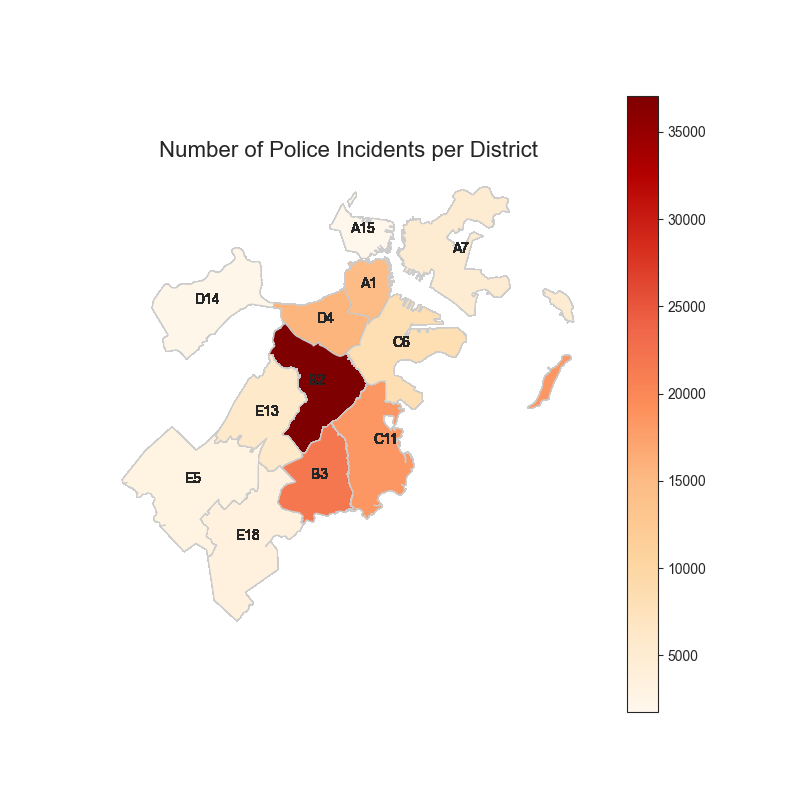

In [ ]:
# Plot districts on map by Incident number
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

map_gdf.plot(
    column="incident_count",
    cmap="OrRd",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,
)

# Add district labels to the map
map_gdf.apply(
    lambda x: ax.annotate(
        text=x["DISTRICT"], xy=x.geometry.centroid.coords[0], ha="center", fontsize=10
    ),
    axis=1,
)

ax.set_title("Number of Police Incidents per District", fontsize=16)
ax.set_axis_off()  # Hide the axes
plt.show()

In [99]:
cops_per_district = (
    map_df.groupby("LOCATION_DISTRICT")["OFFICER_ID"]
    .size()
    .reset_index(name="officer_count")
)
cops_per_district.shape
map_gdf = map_gdf.drop(columns=["LOCATION_DISTRICT"]).merge(
    cops_per_district, left_on="DISTRICT", right_on="LOCATION_DISTRICT", how="left"
)
map_gdf.shape

(137375, 31)

In [100]:
# Police officers Per district
fig, ax = plt.subplots(figsize=(8, 8))

# Create the choropleth map
map_gdf.plot(
    column="officer_count",
    cmap="OrRd",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,  # Display the color legend
    # missing_kwds={
    #     "color": "lightgrey",
    #     "edgecolor": "red",
    #     "hatch": "///"
    # } # Handle districts with no data
)

# Add district labels to the map
map_gdf.apply(
    lambda x: ax.annotate(
        text=x["DISTRICT"], xy=x.geometry.centroid.coords[0], ha="center", fontsize=10
    ),
    axis=1,
)

ax.set_title("Number of Police Officers per District", fontsize=16)
ax.set_axis_off()
plt.show()

In [ ]:
dpt_tract_combined = pd.read_csv('./data/processed_csv/04_combined_dpt_tract.csv')


In [ ]:
dpt_tract_combined.shape

(50544, 691)

In [ ]:
map_gdf = dpt_tract_combined.merge(
    dpt_shape_df, on="DISTRICT", how="left"
)
map_gdf.shape